# 21M.387 Fundamentals of Music Processing
## Pset9

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## Exercise 1

A STFT $\mathcal{X}(h,k)$ is created from a signal $x(n)$ of length $L=1000$ with the parameters:
- $N = 100$, the window length
- $H = 75$, the hop size
- Rectangular Window
- No centering

What is the windowing effect that must be "undone" to properly reconstruct the signal $x(n)$ from $\mathcal{X}(h,k)$? In other words, what function $W(n)$ must be used to create
$$x_r(n) = {\tilde x(n) \over W(n)}$$

Create $W(n)$ and plot it.

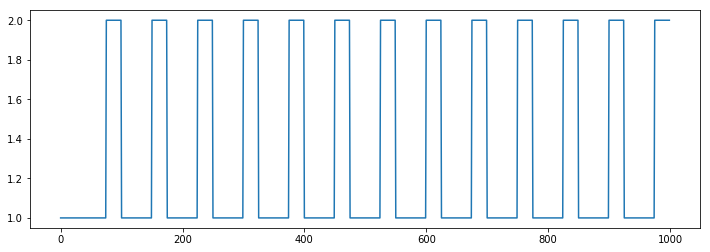

In [2]:
N,H,L = 100, 75, 1000
#what is the windowing effect that must be undone to reconstruct x(n) from X(h,k)?
#what fxn W(n) needed to make 
def count_overlaps(n,N,H):
    return len([i for i in range(0, n+1, H) if i+N > n])
    
W = np.array([count_overlaps(n,N,H) for n in range(L)])
plt.plot(W)


## Exercise 2

Write the function `istft(X, hop_size, centered)`, which creates the time domain signal $x(n)$ from the STFT $\mathcal{X}(h,k)$. 

Inputs:
- `X`: the STFT $\mathcal{X}(h,k)$, as calculated by `fmp.stft()`, assumed to be from a real signal $x(n)$, containing $N/2 + 1$ frequency bins, where $N$ is the original fft size.
- `hop_size`: hop size used to create $\mathcal{X}(h,k)$. 
- `centered`: True if $\mathcal{X}(h,k)$ was created with centered windows.

Outputs:
- `x`, the time domain reconstructed signal.

Tips:
- Assume that the original STFT used a hanning window (`np.hanning`) and no zero padding (ie, the window length is equal to the FFT length).
- The inverse of `np.fft.rfft` is `np.fft.irfft`
- Remember to undo the effects of windowing by calculating $W(n)$. To avoid the numerical instability at the edges due to division by small numbers, set any values of $W(n) < \epsilon$ to be $\epsilon$, using $\epsilon = 0.001$

In [3]:
eps = 0.001
def istft(X, hop_size, centered=True):
    win_length,num_windows = 2*(X.shape[0]-1),X.shape[1]
    han = np.hanning(win_length)
    han[han<eps] = eps
    len_time_sig = (num_windows-1)*hop_size + win_length
    x = np.zeros(len_time_sig)
    for col_i in range(num_windows):
        reg_time_chunk = np.fft.irfft(X[:,col_i])/han
        if centered:
            half_length = int(win_length/2.0)
            start_time_i = col_i*hop_size + half_length
            if win_length % 2 == 0:
                x[start_time_i-half_length:start_time_i+half_length] += reg_time_chunk
            else:
                x[start_time_i-half_length:start_time_i+half_length+1] += reg_time_chunk
        else:
            start_time_i = col_i*hop_size
            x[start_time_i:start_time_i+win_length] += reg_time_chunk
    return x
        
    

To test your funciton:
- Load some audio: $x(n)$
- Take the STFT (`fmp.stft`), and ISTFT (that you just wrote) to create $x_r(n)$, the reconstructed audio
- Plot the error $E(n) = \vert x_r(n) - x(n) \vert$
- Use a few different values for window-length $N$ and hop-size $H$ (especially where $H \ne N/2$).
- Test with both a centered and non-centered STFT / ISTFT

$E(n)$ should be very close to $0$ for almost the whole signal, with the excpetion of edge effects at the very beginning and end of $x_r(n)$.

[ 19930  21626  31695  55810  67439  67611  91648  91960  92287  92630
  92964  93302 127609 163506 163837 164825 177379 199736 210650 211047]
[ 19973  31745  41342  55860  55876  56195  91698  91726 127659 163556
 163578 199786 199802 211388]


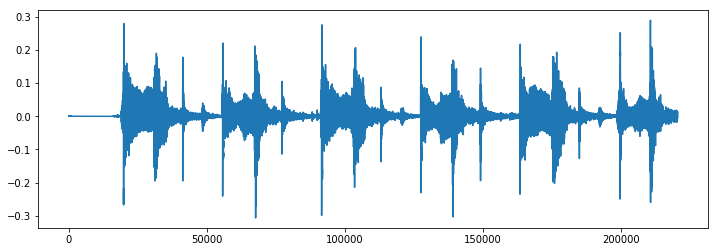

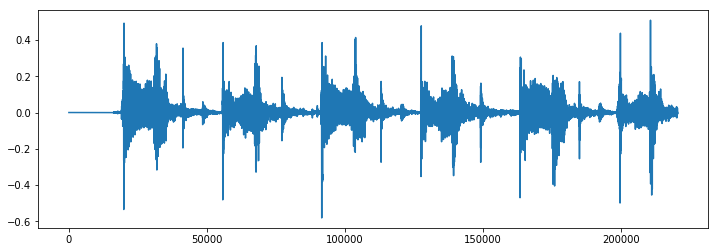

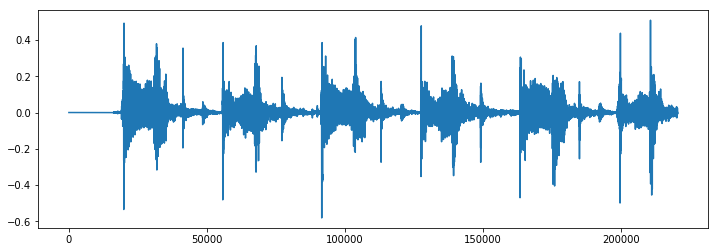

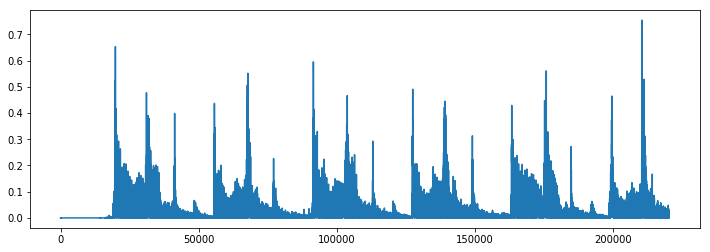

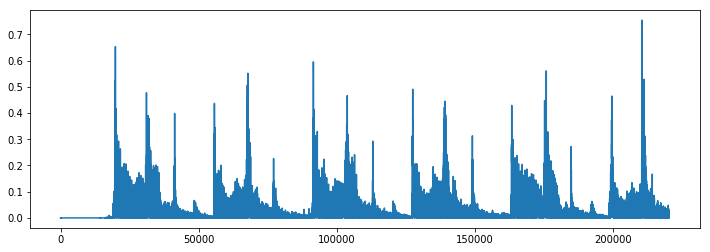

In [4]:
snd = load_wav(filepath="./audio/StingSevenDays.wav",
               t_start = 0, t_end=10)
plt.plot(snd)
#ipd.Audio(snd, rate=22050.)
for n_h in [(100,75)]:#[(200,100), (200,150), (200,50)]:
    N,H = n_h
    spec = fmp.stft(snd, N, H, window=np.hanning(N))

    recon_snd_cent = istft(spec, H, True)
    recon_snd_not_cent = istft(spec, H, False)
    print fmp.find_peaks2(x=snd,thresh=.4,win_len=30)
    print fmp.find_peaks2(x=recon_snd_cent,thresh=.4,win_len=30)
    
    plt.figure()
    plt.plot(recon_snd_cent)
    plt.figure()
    plt.plot(recon_snd_not_cent)
    
    E_cent = abs(recon_snd_cent[:len(snd)] - snd)
    E_not_cent = abs(recon_snd_not_cent[:len(snd)] - snd)
    plt.figure()
    plt.plot(E_cent)
    plt.figure()
    plt.plot(E_not_cent)

## Exercise 3a

From the given signal, create the harmonic and percussive median filtered power spectrograms:
$\tilde{\mathcal{Y}}^h(n,k)$ and $\tilde{\mathcal{Y}}^p(n,k)$ with parameters:
- $N = 1024$
- $H = 512$
- $L_h = 13$ (harmonic median filter length)
- $L_p = 21$ (percussive median filter length)

You can use `fmp.stft` and `scipy.signal.medfilt`.

Plot $\tilde{\mathcal{Y}}^h(n,k)$ and $\tilde{\mathcal{Y}}^p(n,k)$. 

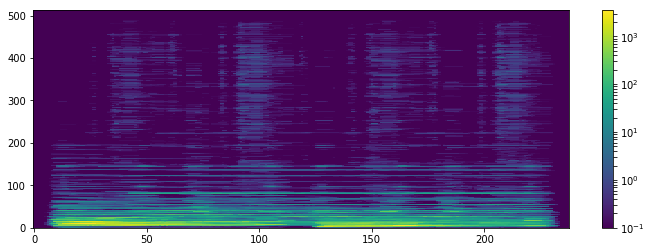

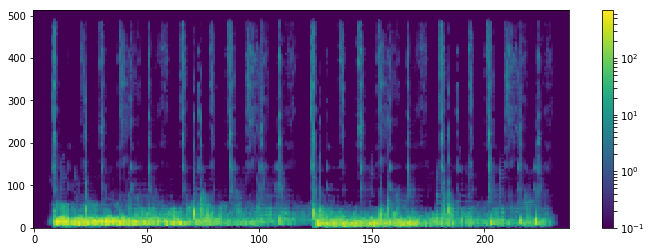

In [5]:
from scipy.signal import medfilt
snd = load_wav("audio/latin_loop.wav")

N,H,Lh,Lp = 1024,512,13,21
spec = abs(fmp.stft(snd, N, H))**2
yh = medfilt(spec,(1,Lh))
yp = medfilt(spec,(Lp,1))

plt.figure()
plot_spectrogram(yh)
plt.figure()
plot_spectrogram(yp)




## Exercise 3b

Instead of creating the usual two masks, create three masks from the filtered spectrograms:

$$
\mathcal{M}^h(n,k) = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h(n,k) \ge \beta \cdot \tilde{\mathcal{Y}}^p(n,k) \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^p(n,k) = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^p(n,k) \gt \beta \cdot \tilde{\mathcal{Y}}^h(n,k) \\  
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^r(n,k) = 1 - \left( \tilde{\mathcal{M}}^h(n,k) + \tilde{\mathcal{M}}^p(n,k) \right)
$$

where $\beta$ is the _separation factor_ and $\beta \ge 1$.  

$\mathcal{M}^r(n,k)$ is the "residual" mask that captures sounds which are neither purely percussive or purely harmonic.

Write the function `make_three_masks` which creates and returns these three masks.  
Inputs:
- `filt_h`, `filt_p`: $\tilde{\mathcal{Y}}^h(n,k)$ and $\tilde{\mathcal{Y}}^p(n,k)$
- beta: $\beta$

Output:
- a tuple of $\mathcal{M}^h(n,k)$, $\mathcal{M}^p(n,k)$, and $\mathcal{M}^r(n,k)$

In [6]:
def make_three_masks(filt_h, filt_p, beta):
    Mh = (filt_h >= beta * filt_p).astype(np.int)
    Mp = (filt_p > beta * filt_h).astype(np.int)
    Mr = 1 - (Mh + Mp)
    return (Mh,Mp,Mr)
    

Plot these three masks with $\beta = 1.5$

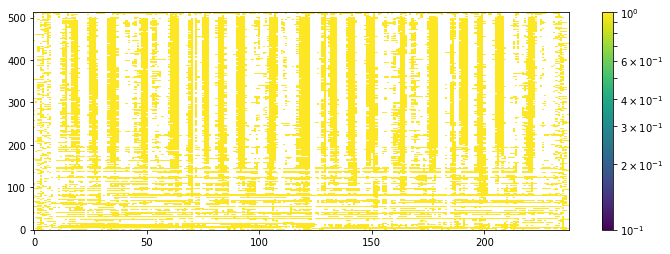

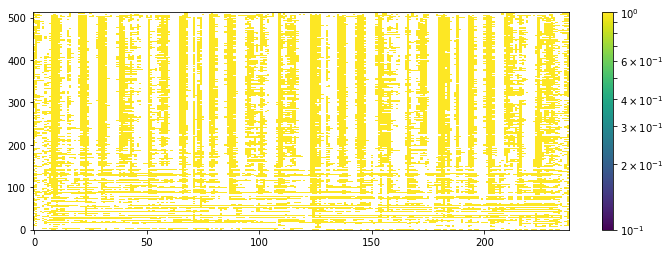

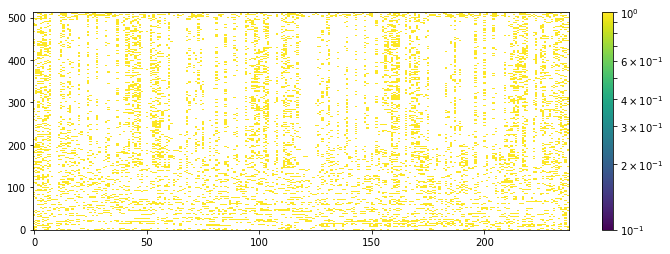

In [7]:
beta = 1.5
Mh,Mp,Mr = make_three_masks(yh,yp,beta)

plt.figure()
plot_spectrogram(Mh)

plt.figure()
plot_spectrogram(Mp)

plt.figure()
plot_spectrogram(Mr)

## Exercise 4

- Reconstruct three signals $x^h(n)$, $x^p(n)$, and $x^r(n)$ from the above masks.
- Listen to the audio. 
- Describe what you hear.
- Try different values of $\beta$ and describe how that changes the results.

In [8]:
x = load_wav("audio/violin_c4.wav")
N,H,Lh,Lp = 1024,512,13,21

def modify_signal(x, beta=1.5):
    spec = fmp.stft(x, N, H)
    yh = medfilt(abs(spec),(1,Lh))
    yp = medfilt(abs(spec),(Lp,1))
    filt = lambda filter_mat: fmp.istft(filter_mat*spec, H, True)
    return map(filt, make_three_masks(yh,yp,beta))

xh,xp,xr = modify_signal(x,beta=1.5) #beta dictates amount of difference between the categories
#having beta is kind of like the way that disambiguate digital signal in computers
ipd.Audio(x,rate=22050.)

In [9]:
ipd.Audio(xh,rate=22050.) #keeps harmonic elements

In [10]:
ipd.Audio(xp,rate=22050.) #keeps percussive elements

In [11]:
ipd.Audio(xr,rate=22050.) #keeps everything else

## Exercise 5

Consider the following matrix $V$, a $(K \times N)$ matrix with non-negative values and $K=9$, $N=7$:
<img src="images/pset_nmf.png" width=300>

Here we only consider the case of perfect non-negative decomposition, such that $V = WH$ exactly and all entries in $W$ and $H$ are non-negative.

By hand (i.e., do not run the NMF solver), determine two different decompositions, that is, two different paris of $W$ and $H$ that satisfy $V = WH$ where the rank of the decomposition is $R=3$. Do not make the second pair trivailly different from the first (by rolling rows and columns, for example).

Provide your answers as python arrays. Note that $V$ is displayed with origin at the bottom left. 

In [22]:
V = np.array([[0,0,0,0,0,0,0],
              [1,1,1,0,0,1,1],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [1,2,2,1,1,1,0],
              [0,0,0,0,0,0,0],
              [0,1,1,1,1,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]])
print V

W1 = np.array(V[:,[0,3,6]])
H1 = np.array([[1,1,1,0,0,1,0],
              [0,1,1,1,1,0,0],
              [0,0,0,0,0,0,1]])
print np.dot(W1,H1)

W2 = np.array(V[:,[0,1,6]])
H2 = np.array([[1,0,0,-1,-1,1,0],
               [0,1,1,1,1,0,0],
               [0,0,0,0,0,0,1]])

print np.dot(W2,H2)


[[0 0 0 0 0 0 0]
 [1 1 1 0 0 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 2 2 1 1 1 0]
 [0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 1 1 0 0 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 2 2 1 1 1 0]
 [0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


## Exercise 6

In order to create a useful matrix factorization, we can pre-seed $W$ with the known pitches of the music. You will do this in two parts.  
First, create the function `make_pitch_spectral_model(fs, fft_len, pitch)`

Inputs:
- `fs`: The sample rate
- `fft_len`: $N$, the FFT length used in making the STFT
- `pitch`: a pitch

Output:
- A 1D vector that is a spectral model for the given pitch (with length $N/2+1$).

Strategy:  
- The resulting vector has zones of non-zero values for each harmonic of the given pitch, and zeros everywhere else.
- The first harmonic zone (fundamental frequency) has a range of +/- 0.5 semitones around the given pitch.
- The rest of the harmonics zones are integer multiples of these frequency bounds.
- The magnitude of each zone is $\alpha^{(h-1)}$ where $h$ is the harmonic number ($h=1$ is the fundamental, $h=2$ is the 2nd harmonic, etc...). Use $\alpha=0.9$.

In [116]:
def pitch_to_freq(p): return 440.0*(2.0**((p-69.0)/12.0))
def freq_to_k(f,N,fs): return f * N / fs

#k*fs/(2*pi) = periods/sec
def make_pitch_spectral_model(fs, fft_len, p):
    
    harmonic_ranges = [map(lambda f:freq_to_k(f,fft_len,fs), \
                           map(lambda x:x*i, \
                               map(pitch_to_freq, [p-0.5,p+0.5]))) 
                        for i in range(1,int(fft_len/2.0))]

    spec_model = np.zeros(int(fft_len/2.0)+1)
    alpha = 1.0
    for h_range in harmonic_ranges:
        for k in range(int(h_range[0]), int(h_range[1])):
            if k < len(spec_model):
                spec_model[k] += alpha
        alpha *= 0.9
    return spec_model

Create and plot spectral models for the pitches 60 and 72 assuming $F_s = 22050$ and $N = 2048$.

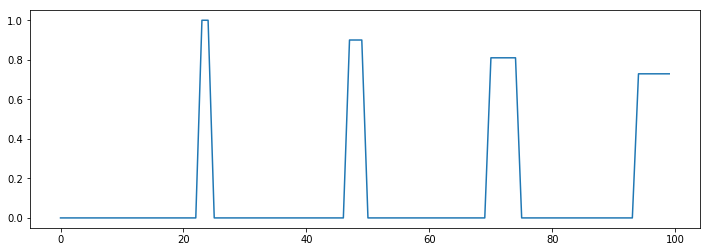

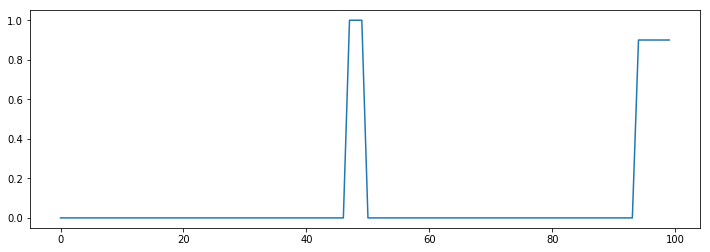

In [117]:
fs,N = 22050.,2048
spec_model_1 = make_pitch_spectral_model(fs,N,60)
spec_model_2 = make_pitch_spectral_model(fs,N,72)
plt.plot(spec_model_1[:100])
plt.figure()
plt.plot(spec_model_2[:100])


## Exercise 7

For the second part, create the function `make_W_from_pitches(fs, fft_len, pitches)` with the help of the above function.

Inputs:
- `fs`: The sample rate
- `fft_len`: $N$, the FFT length used in making the STFT
- `pitches`: a list of pitch

Output:
- $W$ - the initial templates matrix that contains one pitch model at each column


In [118]:
def make_W_from_pitches(fs, fft_len, pitches):
    return np.hstack([make_pitch_spectral_model(fs, fft_len, p).reshape(-1,1) \
            for p in pitches])

Test your function by plotting $W$ generated with pitches from the C major scale from C4 to C5.

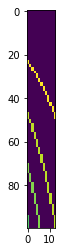

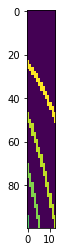

In [119]:
W = make_W_from_pitches(fs, N, range(60,73))
Wi = fmp.build_W(fs, N, range(60,73))
plt.imshow(W[:100,:])
plt.figure()
plt.imshow(Wi[:100,:])

## Exercise 8

In this Exercise, you will run the NMF algorithm on a short snippet of the Mozart _Sonata in F_.  
The score is here and the audio below.

<img src="images/mozart_sonata_f.png" width=500>

In [120]:
snd = load_wav("audio/mozart_sonata_f.wav")
fs = 22050.
ipd.Audio(snd, rate=fs)

Setup:
- Create the STFT of the audio ($N=2048$, $H=1024$)
- Create the list of pitches found in this score (hint: there are 14).
- Use these pitches to create the initial $W$ matrix
- Create an $H$ matrix initialized with all ones.

The NMF algorithm strives to reduce the error $\phi = {\Vert V - WH \Vert}$ where $V$ is the magnitude of the STFT:
- Print the initial value of $\phi$ before running NMF.
- Run NMF to produce optimized $W$ and $H$ using `fmp.nmf(V, Wi, Hi)`. It returns a tuple of $W$ and $H$.
- What is the value of $\phi$ with the optimized $W$ and $H$?
- Finally, plot $W$ and $H$

[[  1.48418779e-01   2.93423597e-01   4.93252567e-01 ...,   1.08073548e-01
    6.10808524e-02   1.75447417e-03]
 [  4.23232421e-01   9.57848749e-01   9.97872779e-01 ...,   3.34278371e-01
    1.85405297e-01   4.13496736e-03]
 [  8.96671841e-01   1.58504066e+00   1.89105635e+00 ...,   9.70683179e-01
    3.47330607e-01   6.59928099e-03]
 ..., 
 [  1.29640034e+00   1.28828295e+00   1.29413131e+00 ...,   1.29778843e+00
    1.29836825e+00   1.29381853e+00]
 [  1.29167737e+00   1.28353174e+00   1.29410729e+00 ...,   1.29757195e+00
    1.29898422e+00   1.29660493e+00]
 [  1.29131252e+00   1.28780749e+00   1.29130366e+00 ...,   1.30104864e+00
    1.30161076e+00   1.29943638e+00]]


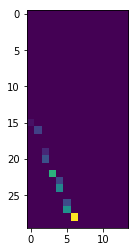

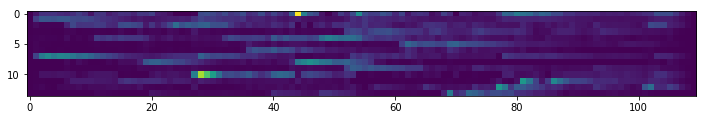

In [124]:
N,hop_size = 2048,1024
pitches = [53,54,57,59,60,62,63,65,69,70,72,76,77,79]
spec = fmp.stft(snd, N, hop_size, window=np.hanning(N))
Wi = make_W_from_pitches(fs, N, pitches)
Hi = np.ones((len(pitches),spec.shape[1]))
V_approx = np.dot(Wi,Hi)
phi = abs(abs(spec) - V_approx)
W,H = fmp.nmf(abs(spec),Wi,Hi)
new_phi = abs(abs(spec) - V_approx)
plt.imshow(W[:30,:])
plt.figure()
plt.imshow(H)
print new_phi

## Exercise 9

In this exercise, separate the left and right hands and create two reconstructed audio clips: $x^L(n)$ and $x^R(n)$:

- Beginning with $H$, the activations matrix, create two different (non overlapping) activation matrices: $H^L$ and $H^R$.
- Create soft masks $M^L$ and $M^R$ using the equations described in the Lecture notes.
- Use these masks to create two STFTs: $\mathcal{X}^L(n,k)$ and $\mathcal{X}^R(n,k)$
- Finally, apply the inverse STFT to create the reconstructed audio clips $x^L(n)$ and $x^R(n)$.

Play both audio clips. Describe what you hear. How good was this source separation?

In [127]:
H_left = H.copy()
H_left[7:,:] = 0
H_right = H.copy()
H_right[0:7,:] = 0

spec_l = fmp.transfer_phase(np.dot(W, H_left), spec)
spec_r = fmp.transfer_phase(np.dot(W, H_right), spec)

x_left = fmp.istft(spec_l, hop_size)
x_right = fmp.istft(spec_r, hop_size)
ipd.Audio(x_left, rate = fs)

In [128]:
ipd.Audio(x_right,rate=fs)

In [ ]:
#Does decent job, not good at filtering out background noise.